In [790]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import re
import contractions
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import  confusion_matrix, classification_report, roc_curve, auc, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifer, DecisionTreeClassifer

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Dropout, Activation, Input
from keras.layers import LSTM,merge
from keras.models import Model
from keras.layers.embeddings import Embedding
from tensorflow.keras.optimizers import Adam
from keras.layers.advanced_activations import ELU
from keras.regularizers import l2

In [684]:
df = pd.read_table('train.tsv')
df.head()

,Id,EssaySet,Score1,Score2,EssayText
0,1,1,1,1,Some additional information that we would need...
1,2,1,1,1,"After reading the expirement, I realized that ..."
2,3,1,1,1,"What you need is more trials, a control set up..."
3,4,1,0,0,The student should list what rock is better an...
4,5,1,2,2,For the students to be able to make a replicat...


In [685]:
df2 = pd.read_table('train_rel_2.tsv')
df2.head()

,Id,EssaySet,Score1,Score2,EssayText
0,1,1,1,1,Some additional information that we would need...
1,2,1,1,1,"After reading the expirement, I realized that ..."
2,3,1,1,1,"What you need is more trials, a control set up..."
3,4,1,0,0,The student should list what rock is better an...
4,5,1,2,2,For the students to be able to make a replicat...


In [686]:
df.shape

(17207, 5)

In [687]:
df2.shape

(17043, 5)

In [688]:
data = pd.concat([df,df2])

In [689]:
data.shape

(34250, 5)

In [690]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34250 entries, 0 to 17042
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         34250 non-null  int64 
 1   EssaySet   34250 non-null  int64 
 2   Score1     34250 non-null  int64 
 3   Score2     34250 non-null  int64 
 4   EssayText  34250 non-null  object
dtypes: int64(4), object(1)
memory usage: 1.6+ MB


In [691]:
data.isnull().sum()

Id           0
EssaySet     0
Score1       0
Score2       0
EssayText    0
dtype: int64

In [692]:
data.describe()

,Id,EssaySet,Score1,Score2
count,34250.000000,34250.000000,34250.000000,34250.000000
mean,13791.279124,5.599445,0.927620,0.925518
std,8248.087563,2.819659,0.893225,0.892463
min,1.000000,1.000000,0.000000,0.000000
25%,6272.250000,3.000000,0.000000,0.000000
50%,14229.000000,6.000000,1.000000,1.000000
75%,20908.000000,8.000000,2.000000,2.000000
max,27588.000000,10.000000,3.000000,3.000000


In [693]:
data['EssaySet'].value_counts()

3     3699
8     3598
7     3598
9     3596
6     3594
5     3590
4     3395
1     3344
10    3280
2     2556
Name: EssaySet, dtype: int64

In [694]:
data['Score1'].value_counts()

0    13510
1    11191
2     8067
3     1482
Name: Score1, dtype: int64

In [695]:
data['Score2'].value_counts()

0    13516
1    11263
2     7977
3     1494
Name: Score2, dtype: int64

In [696]:
data.columns

Index(['Id', 'EssaySet', 'Score1', 'Score2', 'EssayText'], dtype='object')

In [697]:
cat_features = [i for i in data.columns if i != 'Id' and i != 'EssayText']

In [698]:
cat_features

['EssaySet', 'Score1', 'Score2']

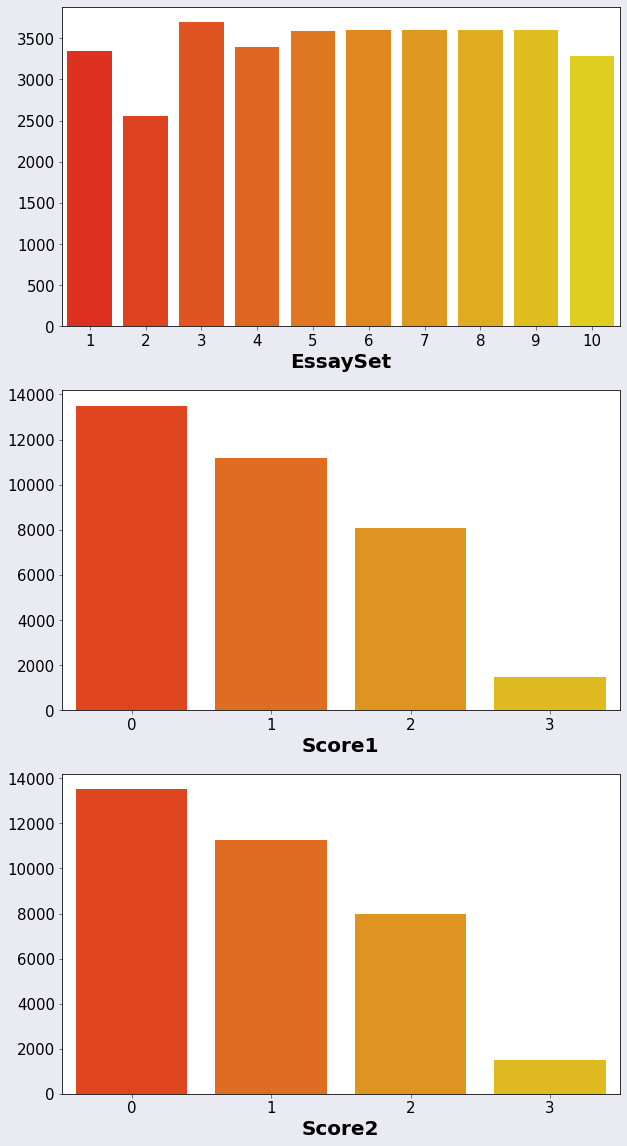

In [699]:
fig, axes = plt.subplots(3, 1, figsize=(10, 20), facecolor='#EAEAF2')

for r in range(3):
    for c in range(1):
        col = cat_features[r]
        sns.countplot(x=data[col], ax=axes[r], palette='autumn', label='Train data')
        axes[r].set_ylabel('')
        axes[r].set_xlabel(col, fontsize=20, fontweight='bold')
        axes[r].tick_params(labelsize=15, width=0.5)
        axes[r].xaxis.offsetText.set_fontsize(4)
        axes[r].yaxis.offsetText.set_fontsize(4)
plt.show()

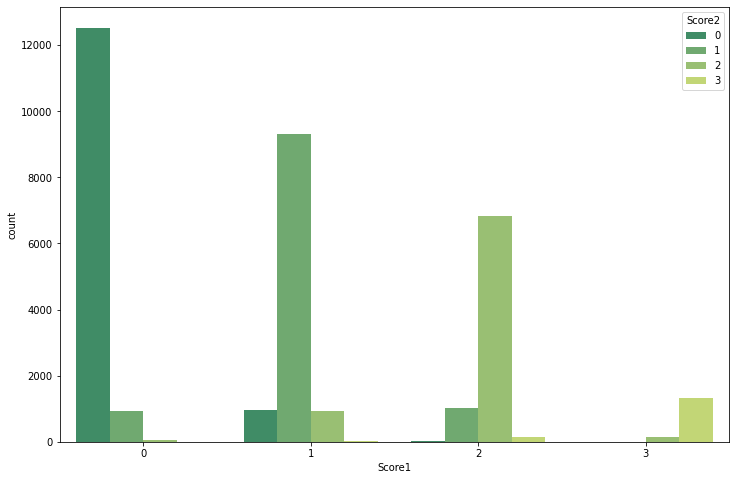

In [700]:
plt.figure(figsize=(12,8))
sns.countplot(x=data['Score1'], hue=data['Score2'], palette='summer');

In [701]:
print(f"Most character answer is: {data['EssayText'].str.len().max()} characters")
print(f"least character answer is: {data['EssayText'].str.len().min()} character")

Most character answer is: 1819 characters
least character answer is: 1 character


**each Answer is from 1 to 1819 characters**

In [702]:
score_0_data = list(data['EssayText'][data['Score1'] == 0].values)
score_1_data = list(data['EssayText'][data['Score1'] == 1].values)
score_2_data = list(data['EssayText'][data['Score1'] == 2].values)
score_3_data = list(data['EssayText'][data['Score1'] == 3].values)

In [703]:
score_0_string = ' '.join(score_0_data)
score_1_string = ' '.join(score_1_data)
score_2_string = ' '.join(score_2_data)
score_3_string = ' '.join(score_3_data)

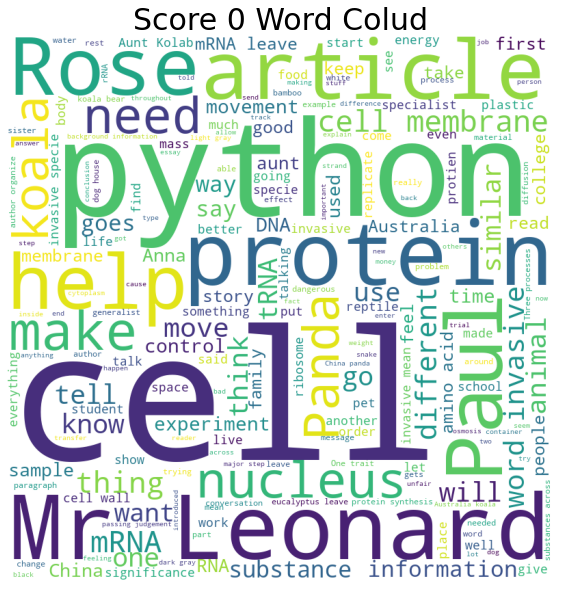

In [704]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = STOPWORDS,
                min_font_size = 10).generate(score_0_string)

plt.figure(figsize = (8, 8), facecolor = None)
plt.title("Score 0 Word Colud", fontdict={'fontsize' : 30})
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

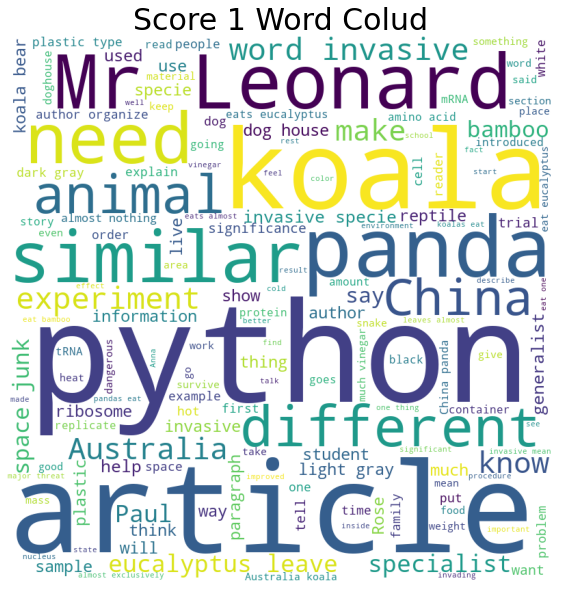

In [705]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = STOPWORDS,
                min_font_size = 10).generate(score_1_string)

plt.figure(figsize = (8, 8), facecolor = None)
plt.title("Score 1 Word Colud", fontdict={'fontsize' : 30})
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

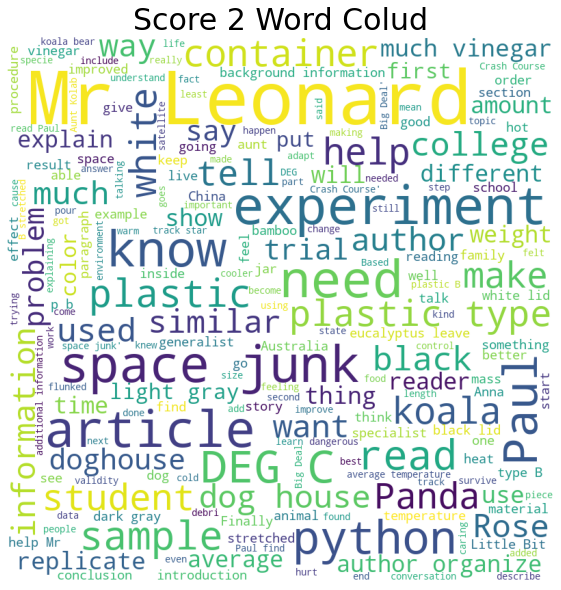

In [706]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = STOPWORDS,
                min_font_size = 10).generate(score_2_string)

plt.figure(figsize = (8, 8), facecolor = None)
plt.title("Score 2 Word Colud", fontdict={'fontsize' : 30})
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

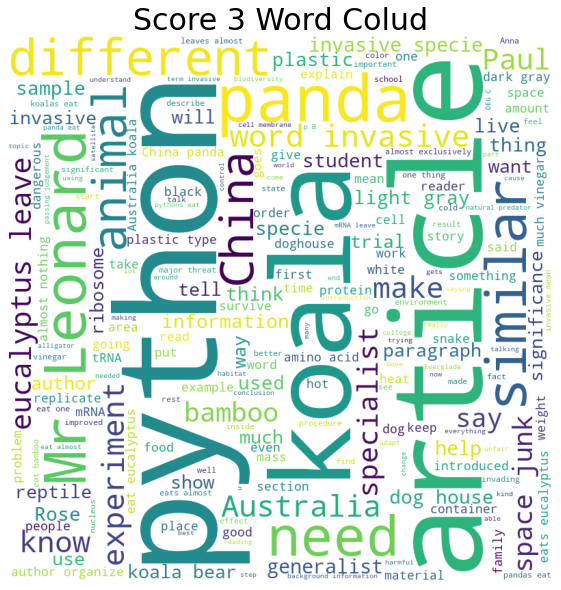

In [707]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = STOPWORDS,
                min_font_size = 10).generate(score_1_string)

plt.figure(figsize = (8, 8), facecolor = None)
plt.title("Score 3 Word Colud", fontdict={'fontsize' : 30})
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

In [708]:
answers_len = data['EssayText'].str.len().values

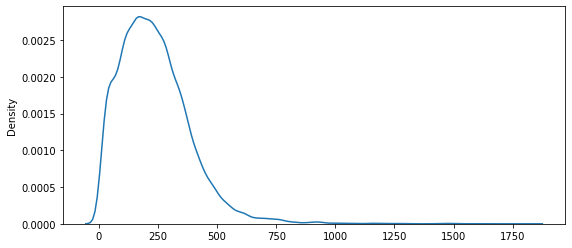

In [709]:
plt.figure(figsize=(9,4))
sns.kdeplot(x=answers_len);

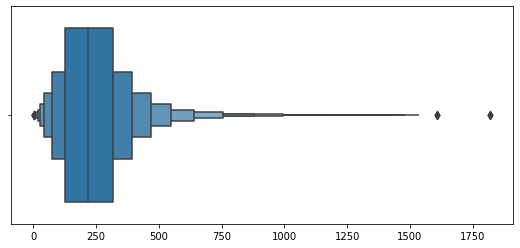

In [710]:
plt.figure(figsize=(9,4))
sns.boxenplot(x=answers_len);

In [711]:
def document_vectorization(document):
    vectorizer = CountVectorizer()
    corpus = vectorizer.fit_transform(document)
    return len(vectorizer.get_feature_names())

In [712]:
number_of_vocabulries = document_vectorization(data['EssayText'])

In [713]:
print(f"Our Vocabulary contains {number_of_vocabulries} word")

Our Vocabulary contains 15921 word


**Before any preprocessing our vocabulry is 15921**

In [714]:
sent_counts = []  # Set of sentence counts in each example response
for x in data['EssayText']:
    sent_counts.append(len(sent_tokenize(x)))

In [715]:
sent_counts[0:5]

[1, 1, 2, 1, 1]

In [716]:
print(f"Max answer contains {max(sent_counts)} sentences")
print(f"Min answer contains {min(sent_counts)} sentences")

Max answer contains 21 sentences
Min answer contains 1 sentences


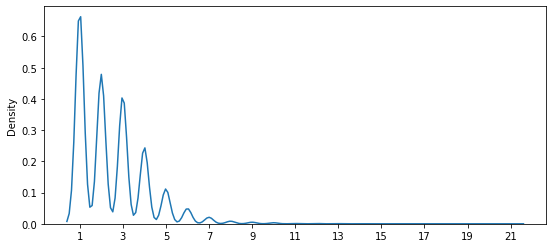

In [717]:
plt.figure(figsize=(9,4))
sns.kdeplot(x=sent_counts);
plt.xticks(np.arange(1,22,2));

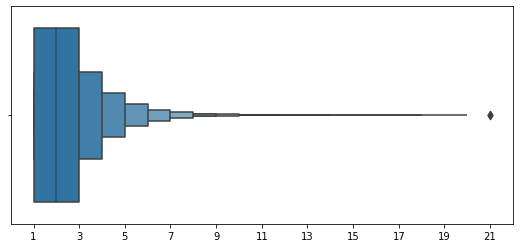

In [718]:
plt.figure(figsize=(9,4))
sns.boxenplot(x=sent_counts)
plt.xticks(np.arange(1,22,2));

In [719]:
word_counts = []
for x in data['EssayText']:
    word_counts.append(len([i for i in word_tokenize(x)]))  

In [720]:
word_counts[0:5]

[58, 54, 39, 18, 33]

In [721]:
print(f"Max answer contains {max(word_counts)} word")
print(f"Min answer contains {min(word_counts)} word")

Max answer contains 369 word
Min answer contains 1 word


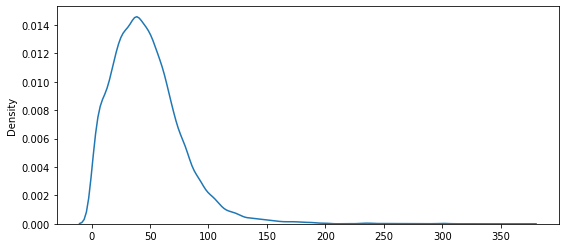

In [722]:
plt.figure(figsize=(9,4))
sns.kdeplot(x=word_counts);

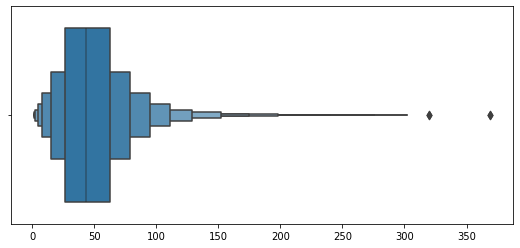

In [723]:
plt.figure(figsize=(9,4))
sns.boxenplot(x=word_counts);

In [724]:
stop_words = stopwords.words('english')

In [725]:
def lowercase_data(data):
    lowercased_data = []
    for sentence in data:
        lowercased_data.append(sentence.lower())
    return lowercased_data



def remove_punctuations(data):
    returned_data = []
    for sentence in data:
        cleaned_data = sentence
        cleaned_data = re.sub(r'[^\w\s].,', '', cleaned_data)
        returned_data.append(cleaned_data)
    return returned_data


def tokenized(data):
    filtered_sentence = []
    for sentence in data:
        filtered_sentence.append(word_tokenize(sentence))
    return filtered_sentence


def stemming_remove_stopwords(data):
    returned_data = []
    word_tokens = tokenized(data)
    for tokens in word_tokens:
        sentence = ""
        for word in tokens:
            if word not in stop_words and word != "would":
                stemmer = PorterStemmer()
                sentence += stemmer.stem(word) + ' '
        returned_data.append(sentence)
    return returned_data 


def preprocessing(data):
    new_data = lowercase_data(data)
    new_data = stemming_remove_stopwords(new_data)
    new_data = remove_punctuations(new_data)
    
    return new_data

In [726]:
data2 = data.copy()

In [727]:
data2.drop('EssayText', axis=1, inplace=True)

In [728]:
data2['EssayText'] = preprocessing(data['EssayText'])

In [729]:
data2['EssayText'].head()

0    addit inform need replic experi much vinegar p...
1    read expir , realiz addit inform need replic e...
2    need trial , control set , exact amount vinega...
3       student list rock better rock wors procedur . 
4    student abl make replic , need tell use much v...
Name: EssayText, dtype: object

In [730]:
number_of_vocabulries_after_preprocess = document_vectorization(data2['EssayText'])
print(f"Our Vocabulary contains {number_of_vocabulries_after_preprocess} word")

Our Vocabulary contains 11988 word


**After preprocessing our vocabulry contains 13259 word**

In [731]:
answers_len_preprocess = data2['EssayText'].str.len()

In [732]:
print(f"Most character answer is: {answers_len_preprocess.max()} character")
print(f"least character answer is: {answers_len_preprocess.min()} character")

Most character answer is: 1049 character
least character answer is: 0 character


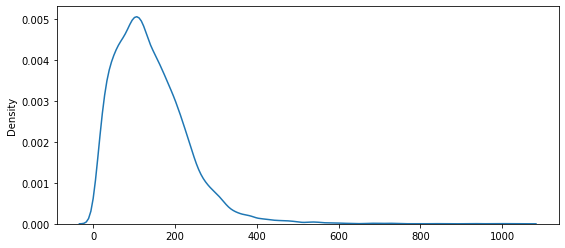

In [733]:
plt.figure(figsize=(9,4))
sns.kdeplot(x=answers_len_preprocess.values);

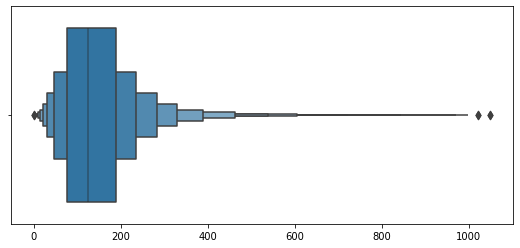

In [734]:
plt.figure(figsize=(9,4))
sns.boxenplot(x=answers_len_preprocess.values);

In [735]:
word_counts_X = []  # Set of sentence counts in each example response
for x in data2['EssayText']:
    word_counts_X.append(len(word_tokenize(x)))

In [736]:
print(f"Max answer contains {max(word_counts_X)} word")

Max answer contains 198 word


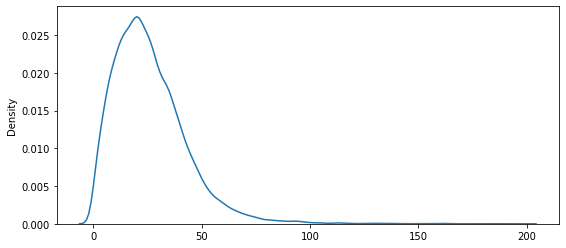

In [737]:
plt.figure(figsize=(9,4))
sns.kdeplot(x=word_counts_X);

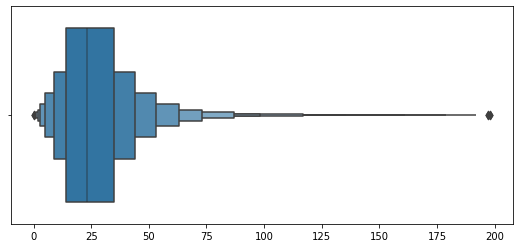

In [738]:
plt.figure(figsize=(9,4))
sns.boxenplot(x=word_counts_X);

In [739]:
texts = data['EssayText']
labels = data['Score1']

In [740]:
top_words = 5000
tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [741]:
word_index = tokenizer.word_index
len(word_index)

16729

In [742]:
sequences[0]

[156,
 304,
 66,
 8,
 186,
 15,
 48,
 2,
 143,
 1,
 54,
 4,
 16,
 68,
 96,
 87,
 14,
 807,
 5,
 70,
 878,
 205,
 16,
 59,
 23,
 857,
 2,
 113,
 2,
 508,
 1,
 149,
 7,
 1,
 192,
 52,
 106,
 3,
 16,
 68,
 625,
 221,
 2,
 113,
 2,
 606,
 1,
 192,
 106,
 111,
 576,
 110,
 50,
 7,
 1,
 96]

In [775]:
max_response_length = 500
data_seq = pad_sequences(sequences, maxlen=max_response_length)

In [776]:
data_seq[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [783]:
labels = data2['Score1']
labels = np.array(labels)

In [784]:
labels[0:5]

array([1, 1, 1, 0, 2], dtype=int64)

In [779]:
data_seq.shape

(34250, 500)

In [780]:
labels.shape

(34250,)

In [772]:
labels2 = to_categorical(np.asarray(labels))

In [782]:
labels2[0:5]

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [785]:
word_counts_X = np.array(word_counts_X)

sent_counts = np.array(sent_counts)

essay_set = data2['EssaySet']
essay_set = np.array(essay_set)

score2_set = data2['Score2']
score2_set = np.array(score2_set)

In [786]:
word_counts_X[0:5]

array([28, 33, 23,  8, 16])

In [787]:
sent_counts[0:5]

array([1, 1, 2, 1, 1])

In [788]:
essay_set[0:5]

array([1, 1, 1, 1, 1], dtype=int64)

In [789]:
score2_set[0:5]

array([1, 1, 1, 0, 2], dtype=int64)

**Split our Data 75% Train 25% Test**

In [792]:
X = np.column_stack((data_seq, sent_counts,word_counts_X,sent_counts, essay_set, score2_set))

In [793]:
X[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [794]:
X.shape

(34250, 505)

In [795]:
y = labels
y[0:5]

array([1, 1, 1, 0, 2], dtype=int64)

In [796]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [798]:
print(f"Number of Training Dataset Examples {X_train.shape[0]}")
print(f"Number of Testing Dataset Examples {X_test.shape[0]}")

Number of Training Dataset Examples 25687
Number of Testing Dataset Examples 8563


In [799]:
def train(model, model_name):
    model.fit(X_train, y_train)
    model_train_score = model.score(X_train, y_train)
    model_test_score = model.score(X_test, y_test)
    print(f"{model_name} model score on Training data: {model_train_score * 100}%\n{model_name} model score on Testing data: {model_test_score * 100}%")

def conf_matrix(model):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True);
    
def class_report(model):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    
def roc(model, model_name):
    y_pred_svm = model.decision_function(X_test)
    svm_fpr, svm_tpr, _ = roc_curve(y_test, y_pred_svm)
    auc_svm = auc(svm_fpr, svm_tpr)
    plt.figure(figsize=(5, 5), dpi=100)
    plt.plot(svm_fpr, svm_tpr, color="darkorange", label=f'{model_name} (auc = %0.3f)' % auc_svm)
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlabel('False Positive Rate -->')
    plt.ylabel('True Positive Rate -->')
    plt.legend()
    plt.show()

In [809]:
lr_model = LogisticRegression(max_iter=10000)
train(lr_model, "Logistic Regression")

Logistic Regression model score on Training data: 85.04691088877642%
Logistic Regression model score on Testing data: 85.0519677683055%


C:\Users\eyada\anaconda3\envs\AI\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [676]:
embedding_vector_length = 32
text_in = Input(shape=(500,), name='text')
embedding = Embedding(output_dim=embedding_vector_length, input_dim=top_words, input_length=500)(text_in)
lstm_1= LSTM(100, return_sequences = True)(embedding)
lstm_2 = LSTM(150)(lstm_1)
features_in = Input(shape=(3,), name='features')
x = merge([lstm_2, features_in], mode='concat')
dropout = Dropout(0.2)(x)
D1 = Dense(200,W_regularizer=l2(0.01),b_regularizer = l2(0.01))(dropout) # try 150 dense after this
ED1 = ELU()(D1)
score = Dense(4, activation='softmax', name='score',W_regularizer=l2(0.01),b_regularizer = l2(0.01))(ED1)
model = Model(input=[text_in, features_in], output=[score])
adam = Adam(lr = 0.001)#, decay = 1e-4) 
print(model.summary())

TypeError: 'module' object is not callable

In [ ]:
model.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])

#Start Training
model.fit([X_train,features_train], y_train, nb_epoch = 20, batch_size=128, validation_split=0.1)